<a href="https://colab.research.google.com/github/krsna540/Hackthons/blob/master/HRAnalytics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # for data visualization
import seaborn as sns # for heatmap plot
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory
# Suppressing Warnings
import warnings
warnings.filterwarnings('ignore')

In [211]:
trainData = pd.read_csv("train_LZdllcl.csv")
testData=pd.read_csv("test_2umaH9m.csv")
print(trainData.shape)
print(testData.shape)

(54808, 14)
(23490, 13)


In [212]:
trainData.isnull().any().sum()

2

In [0]:
trainData.fillna(0, inplace = True) 

In [214]:
trainData.head()

,employee_id,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted
0,65438,Sales & Marketing,region_7,Master's & above,f,sourcing,1,35,5.0,8,1,0,49,0
1,65141,Operations,region_22,Bachelor's,m,other,1,30,5.0,4,0,0,60,0
2,7513,Sales & Marketing,region_19,Bachelor's,m,sourcing,1,34,3.0,7,0,0,50,0
3,2542,Sales & Marketing,region_23,Bachelor's,m,other,2,39,1.0,10,0,0,50,0
4,48945,Technology,region_26,Bachelor's,m,other,1,45,3.0,2,0,0,73,0


In [0]:
from numpy import array
from numpy import argmax
from keras.utils import to_categorical

In [0]:
trainData['region'] = trainData['region'].map(lambda x: int(x.lstrip('region_')))
Gender = {'m': 1,'f': 0}
trainData.gender = [Gender[item] for item in trainData.gender]
trainData = pd.get_dummies(trainData, columns = ['recruitment_channel', 'department', 'education'], drop_first = True)

In [217]:
trainData.head()

,employee_id,region,gender,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted,recruitment_channel_referred,recruitment_channel_sourcing,department_Finance,department_HR,department_Legal,department_Operations,department_Procurement,department_R&D,department_Sales & Marketing,department_Technology,education_Bachelor's,education_Below Secondary,education_Master's & above
0,65438,7,0,1,35,5.0,8,1,0,49,0,0,1,0,0,0,0,0,0,1,0,0,0,1
1,65141,22,1,1,30,5.0,4,0,0,60,0,0,0,0,0,0,1,0,0,0,0,1,0,0
2,7513,19,1,1,34,3.0,7,0,0,50,0,0,1,0,0,0,0,0,0,1,0,1,0,0
3,2542,23,1,2,39,1.0,10,0,0,50,0,0,0,0,0,0,0,0,0,1,0,1,0,0
4,48945,26,1,1,45,3.0,2,0,0,73,0,0,0,0,0,0,0,0,0,0,1,1,0,0


In [218]:
testData.head()

,employee_id,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score
0,8724,Technology,region_26,Bachelor's,m,sourcing,1,24,NaN,1,1,0,77
1,74430,HR,region_4,Bachelor's,f,other,1,31,3.0,5,0,0,51
2,72255,Sales & Marketing,region_13,Bachelor's,m,other,1,31,1.0,4,0,0,47
3,38562,Procurement,region_2,Bachelor's,f,other,3,31,2.0,9,0,0,65
4,64486,Finance,region_29,Bachelor's,m,sourcing,1,30,4.0,7,0,0,61


In [0]:
testData['region'] = testData['region'].map(lambda x: int(x.lstrip('region_')))
Gender = {'m': 1,'f': 0}
testData.gender = [Gender[item] for item in testData.gender]
testData = pd.get_dummies(testData, columns = ['recruitment_channel', 'department', 'education'], drop_first = True)

In [220]:
testData.head()

,employee_id,region,gender,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,recruitment_channel_referred,recruitment_channel_sourcing,department_Finance,department_HR,department_Legal,department_Operations,department_Procurement,department_R&D,department_Sales & Marketing,department_Technology,education_Below Secondary,education_Master's & above
0,8724,26,1,1,24,NaN,1,1,0,77,0,1,0,0,0,0,0,0,0,1,0,0
1,74430,4,0,1,31,3.0,5,0,0,51,0,0,0,1,0,0,0,0,0,0,0,0
2,72255,13,1,1,31,1.0,4,0,0,47,0,0,0,0,0,0,0,0,1,0,0,0
3,38562,2,0,3,31,2.0,9,0,0,65,0,0,0,0,0,0,1,0,0,0,0,0
4,64486,29,1,1,30,4.0,7,0,0,61,0,1,1,0,0,0,0,0,0,0,0,0


In [0]:
trainData=trainData.drop(['employee_id'],axis=1)
train_x=trainData.drop(['is_promoted'],axis=1)
train_y=trainData['is_promoted']

In [222]:
trainData.shape

(54808, 23)

In [0]:
#Removing special charecters from column names
trainData.columns = trainData.columns.str.strip().str.lower().str.replace('>', '').str.replace('?', '').str.replace('%', '').str.replace(' ', '')
testData.columns = testData.columns.str.strip().str.lower().str.replace('>', '').str.replace('?', '').str.replace('%', '').str.replace(' ', '')

In [224]:
##Univariate Analysis - select k best using Chi Square
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

X = trainData.drop(['is_promoted'],axis=1)
y = trainData['is_promoted']
#apply SelectKBest class to extract top 10 best features
bestfeatures = SelectKBest(score_func=chi2, k=10)
fit = bestfeatures.fit(X,y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
print(featureScores.nlargest(15,'Score')) 

                           Specs        Score
8             avg_training_score  5072.973743
7                     awards_won  2054.009313
6                     kpis_met80  1743.827117
4           previous_year_rating   632.801485
0                         region    47.589009
18         department_technology    46.061828
17    department_sales&marketing    37.312181
21      education_master's&above    34.340794
3                            age    27.228103
12                 department_hr    25.964640
5              length_of_service    19.351084
9   recruitment_channel_referred    18.649158
13              department_legal    15.560025
15        department_procurement    11.523545
2                no_of_trainings    10.063491


In [225]:
#Selecting only those columns
columns=featureScores.nlargest(15,'Score').Specs
trainData=pd.DataFrame(trainData, columns=columns)

<bound method NDFrame.head of Specs  avg_training_score  awards_won  ...  department_procurement  no_of_trainings
0                      49           0  ...                       0                1
1                      60           0  ...                       0                1
2                      50           0  ...                       0                1
3                      50           0  ...                       0                2
4                      73           0  ...                       0                1
5                      85           0  ...                       0                2
6                      59           0  ...                       0                1
7                      63           0  ...                       0                1
8                      83           0  ...                       0                1
9                      54           0  ...                       0                1
10                     77           0  ...    

[0.12390472 0.01557453 0.03172529 0.14725137 0.06718741 0.12262528
 0.05024022 0.03417017 0.31024991 0.00519825 0.02017475 0.00508556
 0.00255949 0.00170672 0.01307991 0.01400797 0.0024951  0.01581932
 0.00670963 0.00564671 0.00116082 0.00342686]


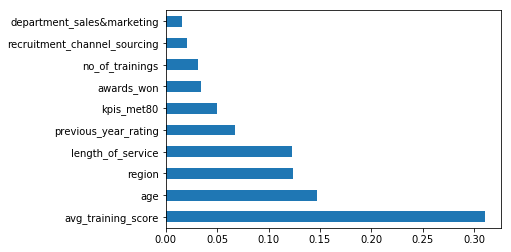

In [226]:
from sklearn.ensemble import ExtraTreesClassifier
import matplotlib.pyplot as plt
model = ExtraTreesClassifier()
model.fit(X,y)
print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.show()

In [227]:
print(feat_importances.nlargest(10))

avg_training_score              0.310250
age                             0.147251
region                          0.123905
length_of_service               0.122625
previous_year_rating            0.067187
kpis_met80                      0.050240
awards_won                      0.034170
no_of_trainings                 0.031725
recruitment_channel_sourcing    0.020175
department_sales&marketing      0.015819
dtype: float64


In [228]:
columns=['avg_training_score','age','region','length_of_service','previous_year_rating','kpis_met80','awards_won','no_of_trainings','department_sales&marketing']
trainData=pd.DataFrame(trainData, columns=columns)
print(trainData.shape)

(54808, 9)


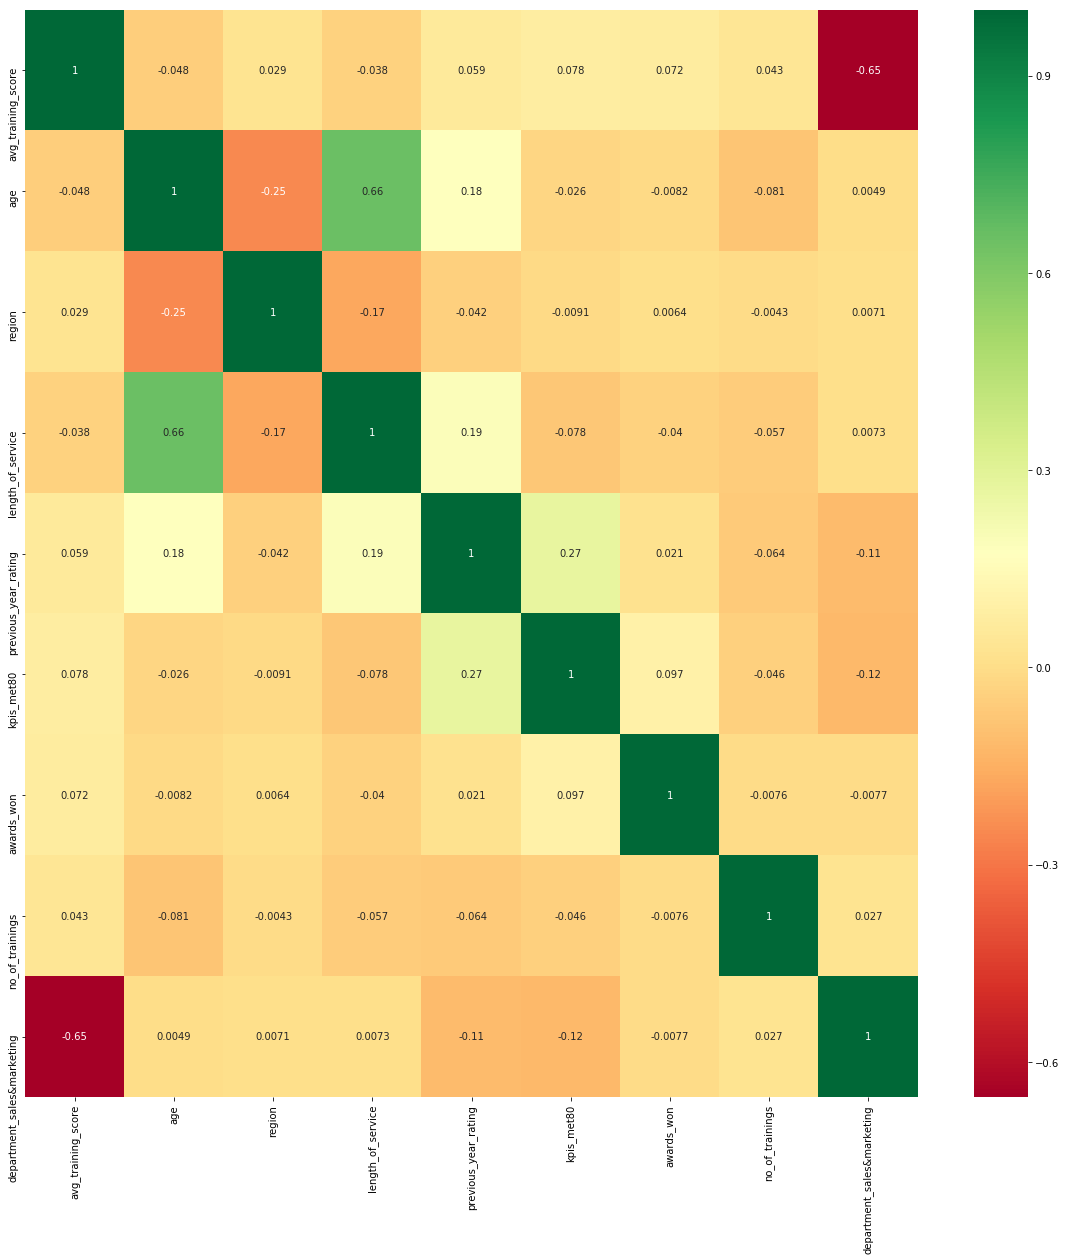

In [230]:
## HeatMap for finding correlation
import seaborn as sns
#get correlations of each features in dataset
corrmat = trainData.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(20,20))
#plot heat map
g=sns.heatmap(trainData[top_corr_features].corr(),annot=True,cmap="RdYlGn")

In [0]:
# Threshold for removing correlated variables
postivethreshold = 0.6
negativethreshold=-0.6

# Absolute value correlation matrix
corr_matrix = trainData.corr().abs()

# Upper triangle of correlations
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Select columns with correlations above threshold
to_drop1 = [column for column in upper.columns if any(upper[column] > postivethreshold)]
to_drop2 = [column for column in upper.columns if any(upper[column] < negativethreshold)]
# Remove the columns
trainData = trainData.drop(columns = to_drop1)
trainData = trainData.drop(columns = to_drop2)

In [232]:
trainData.shape

(54808, 7)

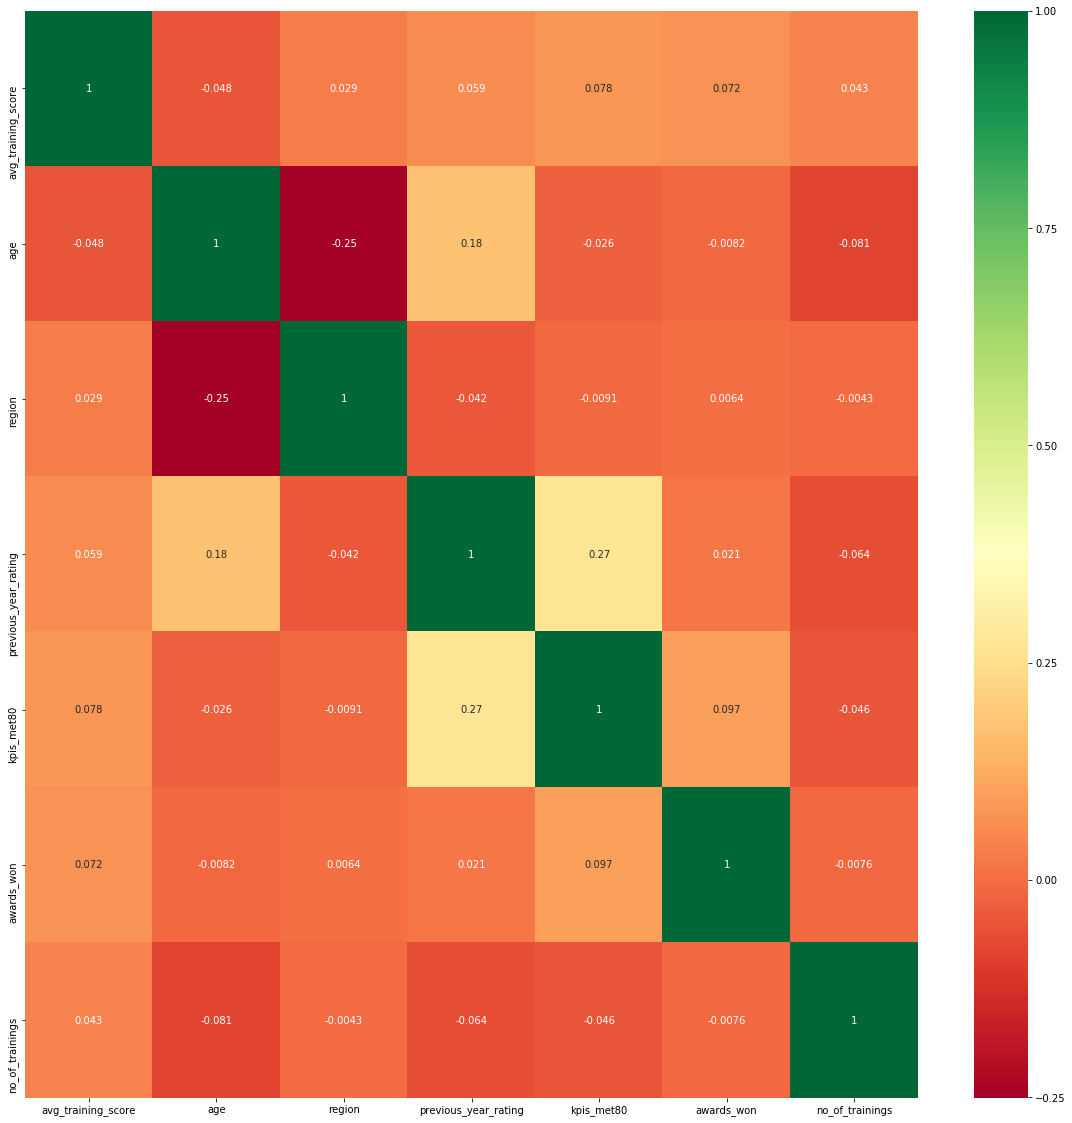

In [233]:
## HeatMap for finding correlation
import seaborn as sns
#get correlations of each features in dataset
corrmat = trainData.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(20,20))
#plot heat map
g=sns.heatmap(trainData[top_corr_features].corr(),annot=True,cmap="RdYlGn")

In [0]:
X = trainData.drop(['is_promoted'],axis=1)
y = trainData['is_promoted']